In [1]:
import pandas as pd
df = pd.read_csv('deletion_effects_threshold_1_30_nucleotides.csv')

In [2]:
df.head()

,transcript_id,deletion_index_start,deletion_index_end,difference,synapse_probability
0,ENSMUST00000000001,0,30,0.001099,0.030640
1,ENSMUST00000000001,15,45,0.001587,0.031128
2,ENSMUST00000000001,30,60,-0.001343,0.028198
3,ENSMUST00000000001,45,75,-0.001099,0.028442
4,ENSMUST00000000001,60,90,0.002197,0.031738


<AxesSubplot:>

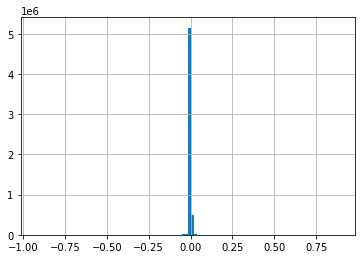

In [3]:
df['difference'].hist(bins = 100)

<AxesSubplot:>

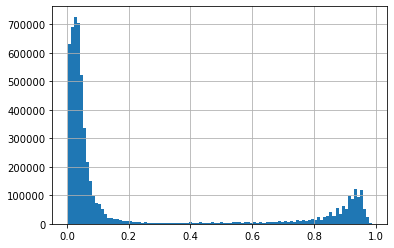

In [4]:
df['synapse_probability'].hist(bins = 100)

<AxesSubplot:xlabel='synapse_probability', ylabel='difference'>

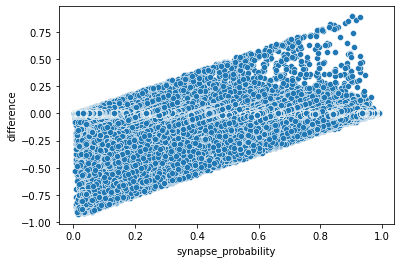

In [5]:
import seaborn as sns
sns.scatterplot(data = df, x = 'synapse_probability', y = 'difference')

In [6]:
# !head /tscc/nfs/home/yumei/Documents/reference_files/Ensembl_mouse_mRNA_cdna_5utr_3utr.csv 


In [7]:
annotation = pd.read_csv('/tscc/nfs/home/yumei/Documents/reference_files/Ensembl_mouse_mRNA_cdna_5utr_3utr.csv')

In [8]:
annotation.head()

,trans_id,index_df1,symbols_df1,gene_id_df1,gene_types,cdna sequences,cdna length,5UTR sequences,5UTR length,index_df2,symbols_df2,gene_id_df2,3UTR sequences,3UTR length
0,ENSMUST00000000001,13,Gnai3,ENSMUSG00000000001,protein_coding,CACACATCCGGTTCTTCCGGGAGCTAGGGGAGCTGACGGAGAAGGC...,3262,CACACATCCGGTTCTTCCGGGAGCTAGGGGAGCTGACGGAGAAGGC...,141,17,Gnai3,ENSMUSG00000000001,GAGGATGGCATAGTAAAAGCTATTACAGGGAGGAGTGTTGAGACCA...,2056
1,ENSMUST00000000003,11,Pbsn,ENSMUSG00000000003,protein_coding,GTCAGTGCACAACTGCCAACTGGGATGCAGAACACTGCTCACGCCA...,902,GTCAGTGCACAACTGCCAACTGGGATGCAGAACACTGCTCACGCCA...,140,0,Pbsn,ENSMUSG00000000003,TGACTCAACAAGATCAGGATTAGCATTACAGATGACATCAGGAATT...,237
2,ENSMUST00000000010,18,Hoxb9,ENSMUSG00000020875,protein_coding,GGTCCGTGTGCCACCTTTTCCCTGCTTGGGCGCCGCGGCGCGAGCG...,2574,GGTCCGTGTGCCACCTTTTCCCTGCTTGGGCGCCGCGGCGCGAGCG...,85,2,Hoxb9,ENSMUSG00000020875,AGATGACCACCCCCCCTTCCCCAGCTCACTCTTATTATTTATGTGA...,1736
3,ENSMUST00000000028,9,Cdc45,ENSMUSG00000000028,protein_coding,TGGAAACACATTCAAATAATGTGTGACTGAATTTACTTTATGTCTA...,2143,TGGAAACACATTCAAATAATGTGTGACTGAATTTACTTTATGTCTA...,313,3,Cdc45,ENSMUSG00000000028,GGAATTCAACTTCTCCAGAAGTGACCTCCTTTTCCTTATTTATATT...,129
4,ENSMUST00000000033,7,Igf2,ENSMUSG00000048583,protein_coding,GGCACTGACCAGTTCGCAAACTGGACATTAGCTTCTCCTGTGAGAA...,3708,GGCACTGACCAGTTCGCAAACTGGACATTAGCTTCTCCTGTGAGAA...,115,10,Igf2,ENSMUSG00000048583,ATCAAATTATGTGGTAATTCTGCAATGTAGTACCATCAATCTGTGA...,3050


In [9]:
annotation.shape

(149443, 14)

In [10]:
ranges = annotation.set_index('trans_id')[['5UTR length', 'cdna length','3UTR length']]

In [11]:
ranges['cdna_end'] = ranges['cdna length']-ranges['3UTR length']

In [12]:
ranges.head()

,5UTR length,cdna length,3UTR length,cdna_end
trans_id,,,,
ENSMUST00000000001,141,3262,2056,1206
ENSMUST00000000003,140,902,237,665
ENSMUST00000000010,85,2574,1736,838
ENSMUST00000000028,313,2143,129,2014
ENSMUST00000000033,115,3708,3050,658


In [13]:
(ranges['cdna_end']-ranges['5UTR length'])%3

trans_id
ENSMUST00000000001    0
ENSMUST00000000003    0
ENSMUST00000000010    0
ENSMUST00000000028    0
ENSMUST00000000033    0
                     ..
ENSMUST00020183809    1
ENSMUST00020183810    2
ENSMUST00020183811    0
ENSMUST00020183812    1
ENSMUST00020183813    2
Length: 149443, dtype: int64

# label if the df on what regions they are in

In [14]:
df = df.merge(ranges, left_on = 'transcript_id', right_index = True)

In [15]:
def return_annotation(row, col):
    if row[col]<= row['5UTR length']:
        return 'UTR5'
    else:
        if row[col]<=row['cdna_end']:
            return 'CDS'
        else:
            return 'UTR3'


In [16]:
df['start_annotation']=df.apply(lambda row: return_annotation(row, 'deletion_index_start'), axis = 1)
df['end_annotation']=df.apply(lambda row: return_annotation(row, 'deletion_index_end'), axis = 1)

In [17]:
pd.crosstab(df['start_annotation'], df['end_annotation'])

end_annotation,CDS,UTR3,UTR5
start_annotation,,,
CDS,3267870,46427,0
UTR3,0,2070849,0
UTR5,50816,6,286862


In [19]:
from pathlib import Path
outdir = Path('/tscc/nfs/home/hsher/ps-yeolab5/karen_data')

In [24]:
df['sequence']=df['transcript_id'].map(annotation.set_index('trans_id')['cdna sequences'])

In [28]:
df['subseq']= df.apply(lambda row: row['sequence'][row['deletion_index_start']:row['deletion_index_end']],
                     axis = 1)

In [31]:
df

,transcript_id,deletion_index_start,deletion_index_end,difference,synapse_probability,5UTR length,cdna length,3UTR length,cdna_end,start_annotation,end_annotation,sequence,subseq
0,ENSMUST00000000001,0,30,0.001099,0.030640,141,3262,2056,1206,UTR5,UTR5,CACACATCCGGTTCTTCCGGGAGCTAGGGGAGCTGACGGAGAAGGC...,CACACATCCGGTTCTTCCGGGAGCTAGGGG
1,ENSMUST00000000001,15,45,0.001587,0.031128,141,3262,2056,1206,UTR5,UTR5,CACACATCCGGTTCTTCCGGGAGCTAGGGGAGCTGACGGAGAAGGC...,TCCGGGAGCTAGGGGAGCTGACGGAGAAGG
2,ENSMUST00000000001,30,60,-0.001343,0.028198,141,3262,2056,1206,UTR5,UTR5,CACACATCCGGTTCTTCCGGGAGCTAGGGGAGCTGACGGAGAAGGC...,AGCTGACGGAGAAGGCCACCGCCCAGCAGA
3,ENSMUST00000000001,45,75,-0.001099,0.028442,141,3262,2056,1206,UTR5,UTR5,CACACATCCGGTTCTTCCGGGAGCTAGGGGAGCTGACGGAGAAGGC...,CCACCGCCCAGCAGAAGACCCGTCTCCGCC
4,ENSMUST00000000001,60,90,0.002197,0.031738,141,3262,2056,1206,UTR5,UTR5,CACACATCCGGTTCTTCCGGGAGCTAGGGGAGCTGACGGAGAAGGC...,AGACCCGTCTCCGCCGGTGTGTGGCGATTC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5722825,ENSMUST00020183810,540,570,0.003906,0.129883,19,637,274,363,UTR3,UTR3,GTCATCGCCACCATCCCTACCAGCAGGCTCAAGTTCCTGAAAGAGG...,TCATCGATGACACCGACCTGGAAGAAGATG
5722826,ENSMUST00020183810,555,585,0.003906,0.129883,19,637,274,363,UTR3,UTR3,GTCATCGCCACCATCCCTACCAGCAGGCTCAAGTTCCTGAAAGAGG...,ACCTGGAAGAAGATGCCGCGCTCAAGCAGA
5722827,ENSMUST00020183810,570,600,0.003906,0.129883,19,637,274,363,UTR3,UTR3,GTCATCGCCACCATCCCTACCAGCAGGCTCAAGTTCCTGAAAGAGG...,CCGCGCTCAAGCAGAACTCGAGCCCGCCGT
5722828,ENSMUST00020183810,585,615,0.003906,0.129883,19,637,274,363,UTR3,UTR3,GTCATCGCCACCATCCCTACCAGCAGGCTCAAGTTCCTGAAAGAGG...,ACTCGAGCCCGCCGTCCTCGCTCAACAAGA


In [33]:
df[['transcript_id', 'deletion_index_start', 'deletion_index_end','difference',
    'synapse_probability','start_annotation','end_annotation','subseq']].to_csv(outdir / 'Mouse_annotated.csv.gz',
                                                                               compression='gzip')